# Background:

Bestselling book trends can be hard to predict before and even after publishing date. Here we do an overall analysis of book trends, from the Amazon Bestseller list from 2015 to 2025.


## 1. Webscraping and  data cleaning :
* Collecting data from the amazon bestsellers list, complementing with Open Library and cleaning dataset.

In [ ]:
#First we install needed pacakges 
pip install requests beautifulsoup4 pandas
pip install selenium

In [ ]:
'''
We use webscrapping to obtain books from the 2024 best seller list: https://www.amazon.com/gp/bestsellers/2024/books/ref=zg_bsar_cal_ye
All done in folder "./src/notebooks/amazon_bestsellers.ipynb"

'''

#2024 
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import pandas as pd
import requests
import re

# Setup headless browser
options = Options()
options.headless = True
driver = webdriver.Chrome(options=options)

def extract_genre(soup):
    breadcrumb = soup.select_one("#wayfinding-breadcrumbs_feature_div")
    if breadcrumb:
        genre_links = breadcrumb.find_all("a")
        genres = [g.get_text(strip=True) for g in genre_links if g.get_text(strip=True)]
        return genres[-1] if genres else 'Unknown'
    return 'Unknown'

def extract_rating(soup):
    rating_tag = soup.select_one("span.a-declarative a.a-popover-trigger span.a-size-base.a-color-base")
    return rating_tag.get_text(strip=True) if rating_tag else 'N/A'

def extract_price(soup):
    price_span = soup.select_one("span.a-price span.a-price-whole")
    if price_span:
        fraction = soup.select_one("span.a-price-fraction")
        return price_span.get_text(strip=True) + "." + fraction.get_text(strip=True) if fraction else price_span.get_text(strip=True)
    return 'N/A'

def extract_reviews(soup):
    reviews_tag = soup.select_one("span#acrCustomerReviewText")
    return reviews_tag.get_text(strip=True) if reviews_tag else 'N/A'

def fetch_book_info_from_openlibrary(title):
    try:
        url = f"https://openlibrary.org/search.json?title={title}"
        response = requests.get(url)
        data = response.json()
        if data['docs']:
            book_info = data['docs'][0]
            publisher = book_info.get('publisher', ['Unknown'])[0]
            published_year = book_info.get('first_publish_year', 'Unknown')
            return publisher, published_year
        else:
            return 'Unknown', 'Unknown'
    except Exception:
        return 'Unknown', 'Unknown'

def extract_year(soup):
    details = soup.select("div#detailBullets_feature_div span.a-list-item")
    for item in details:
        text = item.get_text(strip=True)
        if "Publisher" in text:
            match = re.search(r"(\d{4})", text)
            if match:
                return match.group(1)
    return 'Unknown'

def extract_pages(soup):
    pages = 'Unknown'
    details = soup.select("div#detailBullets_feature_div span.a-list-item")
    for item in details:
        text = item.get_text(strip=True)
        if "pages" in text.lower():
            pages_match = re.search(r"(\d+)\s+pages", text)
            if pages_match:
                pages = pages_match.group(1)
    return pages

def scrape_amazon_bestsellers(year):
    print(f"Scraping Amazon Bestsellers for {year}...")
    base_url = f"https://www.amazon.com/gp/bestsellers/{year}/books"
    book_data = []

    for page in range(1, 6):  # Pages 1–5 = 100 books
        url = f"{base_url}?pg={page}"
        print(f"Fetching page {page}...")
        driver.get(url)
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        book_cards = soup.select("div.zg-grid-general-faceout")

        for card in book_cards:
            try:
                title_tag = card.select_one("div._cDEzb_p13n-sc-css-line-clamp-1_1Fn1y")
                author_tag = card.select_one("div.a-row.a-size-small")
                link_tag = card.select_one("a.a-link-normal")

                if not (title_tag and link_tag and author_tag):
                    continue

                title = title_tag.get_text(strip=True)
                author = author_tag.get_text(strip=True)
                book_url = "https://www.amazon.com" + link_tag['href']

                # Go to book detail page
                driver.get(book_url)
                time.sleep(1.5)
                book_soup = BeautifulSoup(driver.page_source, 'html.parser')

                genre = extract_genre(book_soup)
                rating = extract_rating(book_soup)
                reviews = extract_reviews(book_soup)
                price = extract_price(book_soup)

                publisher, published_year = fetch_book_info_from_openlibrary(title)
                amazon_year = extract_year(book_soup)
                language, pages = extract_language_pages(book_soup)

                if published_year == 'Unknown':
                    published_year = amazon_year

                book_data.append({
                    'title': title,
                    'author': author,
                    'genre': genre,
                    'rating': rating,
                    'price': price,
                    'year': published_year,
                    'pages': pages,
                    'reviews': reviews,
                    'amazon_year': year
                })

            except Exception as e:
                print(f"Error scraping book: {e}")
                continue

    return book_data

# === Set the year to scrape ===
year = 2024
books = scrape_amazon_bestsellers(year)

# Save results to CSV
df = pd.DataFrame(books)
df.to_csv(f"amazon_bestsellers_{year}.csv", index=False)
driver.quit()
print(f"Saved {len(df)} books to amazon_bestsellers_{year}.csv")

We repeat this from 2015-2025

In [ ]:
#We combine it all into one CSV

# Combining all csv
import pandas as pd
import glob

# Load all CSV files from 2015 to 2025
years = range(2015, 2026)
file_names = [f"amazon_bestsellers_{year}.csv" for year in years]

# Read and combine all dataframes
df_list = [pd.read_csv(file) for file in file_names]
combined_df = pd.concat(df_list, ignore_index=True)

# Save to a new CSV
combined_df.to_csv("amazon_bestsellers_2015_2025.csv", index=False)

print("Combined CSV saved as amazon_bestsellers_2015_2025.csv")

In [ ]:
#From here we add column for "Pages" from Open Library

#Fit all page count
import pandas as pd
import requests
import time

# Load your dataset
df = pd.read_csv("amazon_bestsellers_2015_2025.csv")

# Clean column name if needed
df.columns = [col.strip().lower() for col in df.columns]

# Function to get page count from Open Library
def get_pages_from_openlibrary(title, author):
    query = f"{title} {author}"
    url = f"https://openlibrary.org/search.json?title={title}&author={author}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if data["docs"]:
            for book in data["docs"]:
                pages = book.get("number_of_pages_median")
                if pages:
                    return pages
    except:
        pass
    return None

# Replace 'Unknown' in 'pages' column
for idx, row in df.iterrows():
    if str(row["pages"]).strip().lower() == "unknown":
        title, author = row["title"], row["author"]
        print(f"Looking up pages for: {title} by {author}...")
        pages = get_pages_from_openlibrary(title, author)
        if pages:
            df.at[idx, "pages"] = pages
        time.sleep(0.5)  # Be polite to the API


# Save updated CSV
df.to_csv("amazon_bestsellers_pages_filled.csv", index=False)
print("✅ Updated dataset saved as 'amazon_bestsellers_pages_filled.csv'")

In [2]:
#We look for NaN in our dataset
import pandas as pd
df = pd.read_csv("./src/data/amazon_bestsellers_pages_filled.csv")
df.isna().mean()*100 #No NaN so far, we can continue

title          0.0
author         0.0
genre          0.0
rating         0.0
price          0.0
year           0.0
pages          0.0
reviews        0.0
amazon_year    0.0
dtype: float64

In [ ]:
#Next, we fill in columns for Languages and Categories


# Load your dataset
df = pd.read_csv("amazon_bestsellers_pages_filled.csv")

# Prepare new columns
df["Language"] = None
df["Categories"] = None

# Query Google Books API
def fetch_book_data(title, author):
    query = f"intitle:{title}+inauthor:{author}"
    url = f"https://www.googleapis.com/books/v1/volumes?q={query}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if "items" in data and data["items"]:
            info = data["items"][0]["volumeInfo"]
        
            language = info.get("language")
            categories = ", ".join(info.get("categories", []))
            return pages, language, categories
    except:
        pass
    return None, None, None

# Fetch data row-by-row
for idx, row in df.iterrows():
    title, author = row["title"], row["author"]
    print(f"Fetching: {title} by {author}...")
    pages, language, categories = fetch_book_data(title, author)
    df.at[idx, "Total Pages"] = pages
    df.at[idx, "Language"] = language
    df.at[idx, "Categories"] = categories
    time.sleep(0.5)  # Prevent API rate limiting

# ------------------------------------------
# 📚 Override Categories based on genre/author, they were empty
# ------------------------------------------

# Art-related overrides
df.loc[df['genre'].str.contains("use of color", case=False, na=False), "Categories"] = "Art"
df.loc[df['author'].str.contains("Adult Coloring Book Designs", case=False, na=False), "Categories"] = "Art"
df.loc[df['genre'].str.contains("Coloring Books", case=False, na=False), "Categories"] = "Art"
df.loc[df['genre'].str.contains("Drawing", case=False, na=False), "Categories"] = "Art"


# Cooking-related overrides
df.loc[df['genre'].str.contains("Poultry", case=False, na=False), "Categories"] = "Cooking"

# Non Fiction
non_fiction_conditions = [
    "personal finance",
    "Social Psychology & Interactions",
    "Marriage & Divorce",
    "Reference",
    "School",
    "Parents",
    "Book Design",
    "Sounds",
    "Creativity",
    "Educational Psychology",
    "Quizzes",
    "Motherhood",
    "Faith",
    "Homeopathy",
    "Girls & Women"
    
]
for term in non_fiction_conditions:
    df.loc[df['genre'].str.contains(term, case=False, na=False), "Categories"] = "Non Fiction"

# Fiction
fiction_conditions = [
    "Epic",
    "Fantasy & Magic",
    "Mystery & Suspense",
    "Rabbits",
    "Southern",
    "Boys & Men",
    "Occult",
    "Paranormal",
    "Family Life"
]
for term in fiction_conditions:
    df.loc[df['genre'].str.contains(term, case=False, na=False), "Categories"] = "Fiction"
    df.loc[df['author'].str.contains("Rick Riordan", case=False, na=False), "Categories"] = " Juvenile Fiction"
    df.loc[df['author'].str.contains("J. K. Rowling", case=False, na=False), "Categories"] = " Fiction"
    df.loc[df['author'].str.contains("Ray Bradbury", case=False, na=False), "Categories"] = " Fiction"




# Save as new CSV
df.to_csv("amazon_bestsellers.csv", index=False)
print("✅ Enriched dataset saved as 'amazon_bestsellers.csv'")

In [ ]:
#Make another column with genre, Binary column, fiction or non fiction and Publisher
import pandas as pd
import requests
import time
df = pd.read_csv("amazon_bestsellers.csv")


# ----------------------------
# Create new "Genres" column
# ----------------------------
def classify_genre(cat):
    if not isinstance(cat, str):
        return "Non Fiction"
    
    cat_lower = cat.lower()
    
    if "nonfiction" in cat_lower or "non fiction" in cat_lower:
        return "Non Fiction"
    elif "fiction" in cat_lower:
        return "Fiction"
    else:
        return "Non Fiction"

df["Genres"] = df["Categories"].apply(classify_genre)

# Save the final CSV
df.to_csv("amazon_bestsellers_final.csv", index=False)
print("✅ File saved as 'amazon_bestsellers_final.csv'")


#We look for Publisher
import re
import random
from tqdm import tqdm  # For a nicer progress bar

# Load your CSV
df = pd.read_csv("amazon_bestsellers_final.csv")

# Function to get publisher from Google Books API with improved search
def get_publisher_google_books(title, author=None):
    base_url = "https://www.googleapis.com/books/v1/volumes"
    
    # Clean the title for better search results
    clean_title = re.sub(r'[^\w\s]', '', title)
    
    # For long titles, use only the first part before any colon or parenthesis
    short_title = re.split(r'[:(]', clean_title)[0].strip()
    
    # Try different search strategies in order of specificity
    search_queries = []
    
    if author and pd.notna(author):
        # Full title with author
        search_queries.append((f"intitle:\"{clean_title}\" inauthor:{author}", 5))
        # Short title with author
        search_queries.append((f"intitle:\"{short_title}\" inauthor:{author}", 5))
    
    # Just the title queries
    search_queries.append((f"intitle:\"{clean_title}\"", 5))
    search_queries.append((f"intitle:\"{short_title}\"", 10))  # More results for shorter title
    
    # Try each search strategy until we find a publisher
    for query, max_results in search_queries:
        params = {"q": query, "maxResults": max_results}
        
        try:
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            items = data.get("items", [])
            
            # Check through multiple results for better matching
            if items:
                for item in items:
                    volume_info = item.get("volumeInfo", {})
                    publisher = volume_info.get("publisher")
                    
                    if publisher:
                        return publisher
                
            # If we found items but no publisher, continue to next search strategy
        except Exception as e:
            print(f"Error fetching '{title}' with query '{query}': {e}")
        
        # Small delay between different search strategies
        time.sleep(0.5)
    
    return None

# Create a cache to store already fetched publishers
publisher_cache = {}

# Create a new column with publisher info
df["publisher"] = None  # Initialize the column

# Process in batches to handle API limits better
batch_size = 100
total_books = len(df)

for batch_start in range(0, total_books, batch_size):
    batch_end = min(batch_start + batch_size, total_books)
    batch = df.iloc[batch_start:batch_end]
    
    print(f"\nProcessing batch {batch_start//batch_size + 1}/{(total_books-1)//batch_size + 1}")
    
    for i, row in tqdm(batch.iterrows(), total=len(batch), desc="Fetching publishers"):
        title = row["title"]
        author = row.get("author", None)  # Use author info if available
        
        # Check cache first
        if title in publisher_cache:
            df.at[i, "publisher"] = publisher_cache[title]
            continue
            
        publisher = get_publisher_google_books(title, author)
        publisher_cache[title] = publisher  # Cache the result
        df.at[i, "publisher"] = publisher
        
        # Random delay between 1-2 seconds to prevent rate limiting
        time.sleep(1 + random.random())

# Manually fix known missing entries or common issues
manual_fixes = {
    "StrengthsFinder 2.0": "Gallup Press",
    "The Four Agreements": "Amber-Allen Publishing",
    "You Are a Badass": "Running Press",
    "The 5 Love Languages": "Northfield Publishing",
    "Crazy Rich Asians": "Doubleday",
    "The Alchemist": "HarperOne",
    "Enchanted Forest: An Inky Quest and Coloring book (Activity Books, Mindfulness and Meditation, Illustrated Floral Prints)": "Laurence King Publishing",
    "Ultimate Sticker Book: Frozen: More Than 60 Reusable Full-Color Stickers": "DK Children",
    "Where Is Baby's Belly Button? A Lift-the-Flap Book": "Little Simon",
    "Harry Potter and the Cursed Child, Parts 1 & 2, Special Rehearsal Edition Script": "Arthur A. Levine Books",
    "The Shack: Where Tragedy Confronts Eternity": "Windblown Media",
    "Last Week Tonight with John Oliver Presents: A Day in the Life of Marlon Bundo (HBO)": "Chronicle Books",
    "D&D 2014 Player's Handbook (Dungeons & Dragons Core Rulebook)": "Wizards of the Coast",
    "Crazy Rich Asians (Crazy Rich Asians Trilogy)": "Anchor Books",
    "Difficult Riddles For Smart Kids: 300 Difficult Riddles And Brain Teasers Families Will Love (Thinking Books for Kids)": "M & M Kidz",
    "Fahrenheit" : " Simon and Schuster",
    "Diary of a Wimpy Kid #13: Meltdown": "Harry N. Abrams",
    "Things We Never Got Over (Knockemout)": "Hodder & Stoughton",
    "Run, Rose, Run: A Novel": "Little, Brown and Company",
    "Haunting Adeline (Cat and Mouse Duet)" : "Independently published",
    "Murdle: Volume 1 (Murdle, 1)":"Griffin"

}

# Apply manual fixes
df["publisher"] = df.apply(
    lambda row: manual_fixes.get(row["title"], row["publisher"]), axis=1
)

# Count and report missing publishers
missing_count = df["publisher"].isna().sum()
if missing_count > 0:
    print(f"\n⚠️ {missing_count} books still missing publisher information.")
    print("Missing publisher for:")
    for title in df[df["publisher"].isna()]["title"].head(10):  # Show first 10 missing
        print(f"- {title}")
    if missing_count > 10:
        print(f"...and {missing_count - 10} more.")

# Save the updated dataset
output_file = "amazon_final.csv"
df.to_csv(output_file, index=False)
print(f"\n✅ Done! Saved to '{output_file}'")

# Print publisher statistics
publisher_counts = df["publisher"].value_counts().head(10)
print("\n📊 Top 10 publishers in the dataset:")
for publisher, count in publisher_counts.items():
    if pd.notna(publisher):
        print(f"- {publisher}: {count} books")

In [3]:
df = pd.read_csv("./src/data/amazon_final.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        656 non-null    object 
 1   author       656 non-null    object 
 2   genre        656 non-null    object 
 3   rating       656 non-null    float64
 4   price        656 non-null    object 
 5   year         656 non-null    int64  
 6   pages        656 non-null    object 
 7   reviews      656 non-null    object 
 8   amazon_year  656 non-null    int64  
 9   Language     654 non-null    object 
 10  Categories   656 non-null    object 
 11  Total Pages  0 non-null      float64
 12  Genres       656 non-null    object 
 13  publisher    656 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 71.9+ KB


In [5]:
df.head(10)

,title,author,genre,rating,price,year,pages,reviews,amazon_year,Language,Categories,Total Pages,Genres,publisher
0,First 100 Words: A Padded Board Book,Roger Priddy,Vocabulary & Spelling,4.7,3..88,2011,24,"38,701 ratings",2015,en,Juvenile Nonfiction,NaN,Non Fiction,Priddy Books US
1,The Life-Changing Magic of Tidying Up: The Jap...,Marie Kondō,"Cleaning, Caretaking & Relocating",4.5,9..42,2017,224,"59,251 ratings",2015,en,House & Home,NaN,Non Fiction,Ten Speed Press
2,Laugh-Out-Loud Jokes for Kids,Rob Elliott,Humorous,4.6,4..64,2022,128,"12,125 ratings",2015,en,Juvenile Nonfiction,NaN,Non Fiction,HarperCollins
3,Secret Garden: An Inky Treasure Hunt and Color...,Johanna Basford,Use of Color,4.7,10..18,2013,96,"15,936 ratings",2015,en,Art,NaN,Non Fiction,National Geographic Books
4,StrengthsFinder 2.0,Gallup,Management,4.1,28..52,2007,175,"8,423 ratings",2015,es,Business & Economics,NaN,Non Fiction,Gallup Press
5,Go Set a Watchman: A Novel,Harper Lee,Cultural Heritage,3.8,12..95,2018,288,"54,069 ratings",2015,en,Fiction,NaN,Fiction,Harper
6,Enchanted Forest: An Inky Quest and Coloring b...,Johanna Basford,Coloring Books,4.8,14..19,2015,84,"8,419 ratings",2015,en,Art,NaN,Non Fiction,Laurence King Publishing
7,All the Light We Cannot See,Anthony Doerr,World War II & Holocaust,4.5,12..93,2014,531,"232,435 ratings",2015,en,Fiction,NaN,Fiction,Simon and Schuster
8,The Girl on the Train,Paula Hawkins,Suspense,4.1,12..20,2014,336,"494,411 ratings",2015,en,Alcoholics,NaN,Non Fiction,Random House
9,Adult Coloring Book: Stress Relieving Patterns,Blue Star Coloring,Use of Color,4.5,9..95,2015,96,"4,363 ratings",2015,en,Art,NaN,Non Fiction,Blue Star Press


In [ ]:
#We can drop "Total pages " and "Language" as they are duplicated and not relevant
df.drop(axis = 1, columns = ["Total Pages", "Language"] )

## 2.  Analysis I :
 * Continue cleanup and preparing dataset for analysis
 * From (./src/data/amazon_analysis.ipynb)

In [ ]:
#Set index as book_id
df.index.name = 'Book_Id'

#Change column names: "genres" to "Themes", "pages" to "Total_Pages"
df.rename(columns={'Genre': 'Theme', 'pages': 'Total_Pages'}, inplace=True)

#Capitalize all columns

df.columns = [col.capitalize() for col in df.columns]
df.columns

#Remove "ratings" from the column "Reviews"
df['Reviews'] = df['Reviews'].str.replace('ratings', '', regex=False).str.strip()

#Remove one ".." from the column "Price"
df['Price'] = df['Price'].str.replace('..', '.', regex=False).str.strip()

#Replace "." for "," in Rating and "," for "."" in "Reviews" and in Price
df['Price'] = df['Price'].str.replace('.', ',', regex=False).str.strip()
df['Reviews'] = df['Reviews'].str.replace(',', '.', regex=False).str.strip()

#Convert "Price" and "Rating" to float and "Reviews" to int
df['Rating'] = df['Rating'].astype(str).str.replace(',', '.', regex=False).astype(float)
df['Price'] = df['Price'].astype(str).str.replace(',', '.', regex=False).astype(float)

df['Reviews'] = df['Reviews'].str.replace(r'[^0-9]', '', regex=True).astype(int)

#Add a space in between words for Publisher

df['Publisher'] = df['Publisher'].apply(lambda x: re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', x))

In [ ]:
# Harper in oublisher is Harper Collins, let´s replace that
df['Publisher'] = df['Publisher'].str.replace(r'Harper\s?Collins', 'Harper Collins', regex=True)
#Group all Penguin, Random House together
df['Publisher'] = df['Publisher'].str.replace(
    r'(?i)\b(penguin.*|random house.*)\b', 'Penguin Random House', regex=True

#Replace some publishers that I see are wrong
df.loc[df['Title'].str.contains('atomic habits', case=False, na=False), 'Publisher'] = 'Penguin Random House'
df.loc[df['Title'].str.contains('the house of my mother', case=False, na=False), 'Publisher'] = 'Simon and Schuster'
df.loc[df['Title'].str.contains("Don't Believe Everything You Think", case=False, na=False), 'Publisher'] = 'Authors Equity'


#Correct Authors names
df['Author'] = df['Author'].str.title()

In [ ]:
# Check for duplicate rows (based on all columns)
duplicate_rows = df[df.duplicated()]

# Or check for duplicates based on specific columns (e.g., title + author)
duplicate_titles = df[df.duplicated(subset=["Title", "Author"])]

# See how many there are
print("Total full duplicates:", len(duplicate_rows))
print("Total title-author duplicates:", len(duplicate_titles))

# Show examples
print(duplicate_titles[["Title", "Author"]].head())

In [ ]:
#Save dataset
df.to_csv("amazon_cleaned.csv", index=False)

Future Work:

We can preprocess the datasets that are extracted from Amazon. Preprocessing can include the following.

Replacing the missing values if any with the appropriate values.
Removing the duplicated rows.
Taking a note of any unusual values.
Adjusting the outliers as they can hamper the further analysis of the data.

We can analyze the datasets further to check the following.
Which genre is the most popular with highest user ratings?
List of Authors which have top selling books in the multiple genres?
List of Authors having multiple top selling books in the same genre?
Top 10 books with the maximum selling price across all the genres.
What is the trend of star rating and number of user ratings?
Books which have the highest star ratings and highest number of user ratings.


| Columna/Variable | Descripción |
| ---------------- | ----------- |
| Title     | Title of the book|
| Author    | Author of the book |
| Theme   | Recurring themes of the book |
| Rating    | Average rating of the book, by amazon customers |
| Price    | Book price on amazon (in $) |
| Year   | Year it was published |
| Total_pages     | Number of pages in the book|
| Reviews     | Number of reviews for the book  |
| Amazon_year    | Year it was a bestseller on Amazon|
| Categories | Fiction on Non Fiction |
| Genres    | Genre of the book |
| Publisher   | Publishing house for the book |

### Univariant Analysis

* From (./src/data/amazon_analysis.ipynb)
* From (./src/data/amazon_analysis_II.ipynb)

In [16]:
from src.utils.bootcampviztools import plot_categorical_relationship_fin, pinta_distribucion_categoricas, plot_grouped_histograms,\
    plot_grouped_boxplots, plot_combined_graphs, plot_categorical_numerical_relationship, bubble_plot,\
        grafico_dispersion_con_correlacion
from scipy.stats import chi2_contingency, mannwhitneyu

In [6]:
df= pd.read_csv("./src/data/amazon_cleaned.csv")

In [7]:
df_tipificacion = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]).T.rename(columns = {0: "Card",\
                                                                                                                                 1: "%_Card", 2: "Tipo"})
df_tipificacion["Clasificada_como"] = "Categorica" 
df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
df_tipificacion.loc[df_tipificacion["Card"] > 13, "Clasificada_como"] ="Numerica Discreta"
df_tipificacion.loc[df_tipificacion["%_Card"] > 30, "Clasificada_como"] = "Numerica Continua"
df_tipificacion

,Card,%_Card,Tipo,Clasificada_como
Title,403,61.432927,object,Numerica Continua
Author,298,45.426829,object,Numerica Continua
Theme,231,35.213415,object,Numerica Continua
Rating,12,1.829268,float64,Categorica
Price,332,50.609756,float64,Numerica Continua
Year,56,8.536585,int64,Numerica Discreta
Total_pages,122,18.597561,object,Numerica Discreta
Reviews,418,63.719512,int64,Numerica Continua
Amazon_year,11,1.676829,int64,Categorica
Categories,51,7.77439,object,Numerica Discreta


In [17]:
categoricas = ["Rating","Amazon_year","Genres"]
numericas = ["Price","Year", "Total_pages", "Reviews","Categories" "Publisher"]

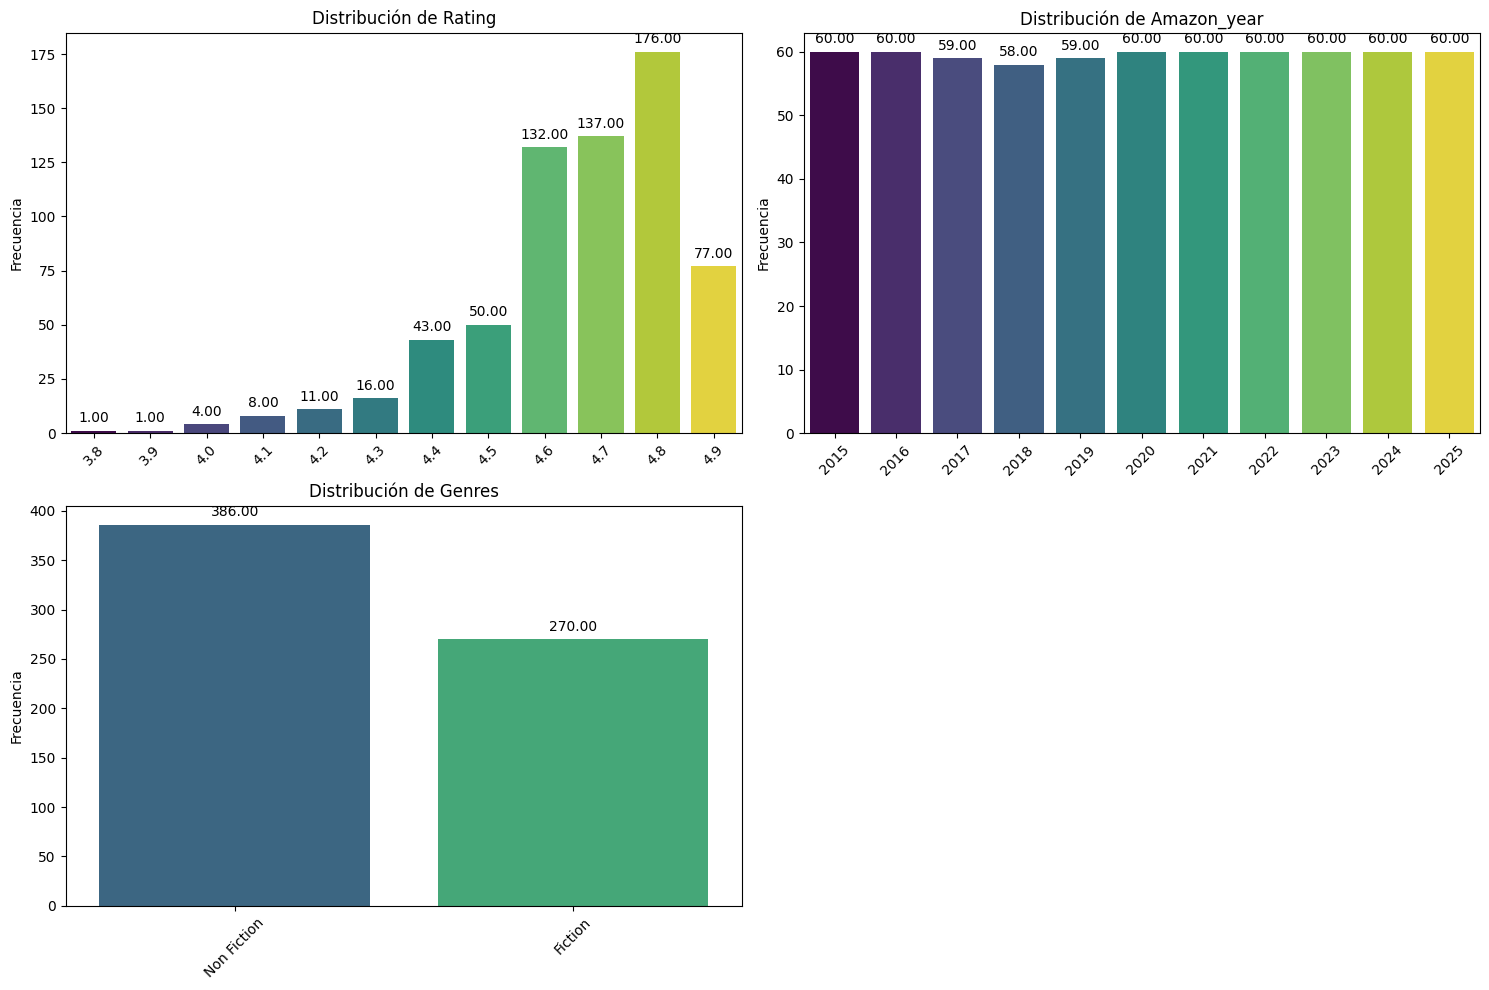

In [18]:
pinta_distribucion_categoricas(df, categoricas, mostrar_valores= True)

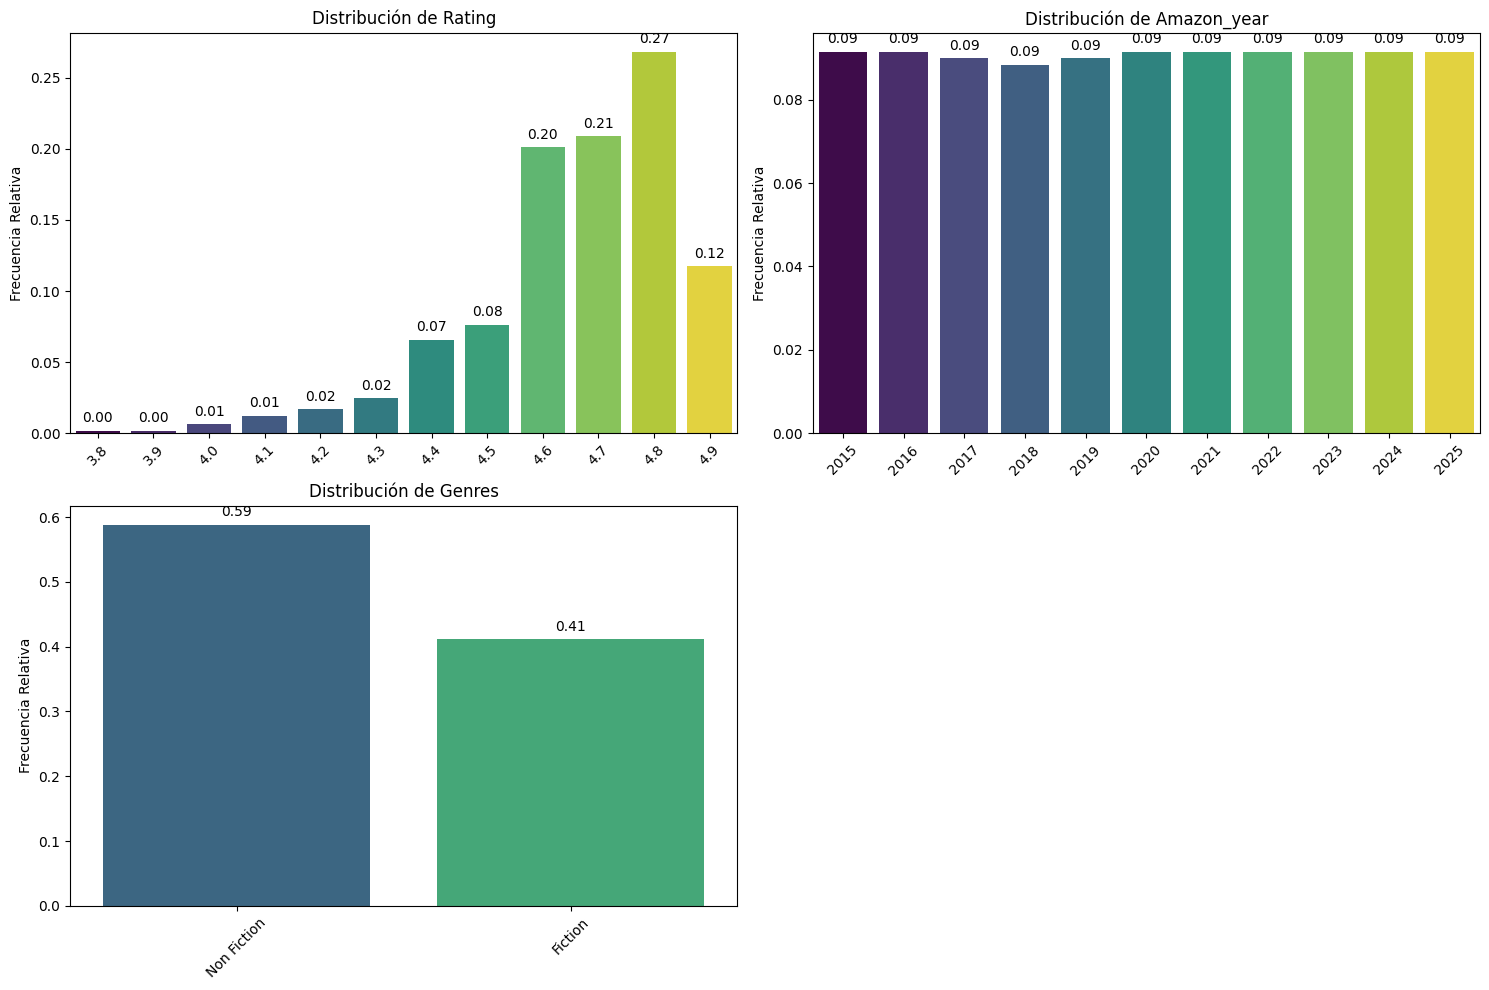

In [19]:
# Now relative Frequency:

pinta_distribucion_categoricas(df, categoricas,relativa= True, mostrar_valores= True)

In [20]:
#Mean std dev, median for numerical values:
df[["Price","Rating", "Reviews"]].describe()

,Price,Rating,Reviews
count,656.000000,656.000000,656.000000
mean,11.712759,4.662957,78119.698171
std,6.845434,0.186285,103969.803235
min,1.670000,3.800000,694.000000
25%,7.880000,4.600000,17467.750000
50%,10.050000,4.700000,38983.500000
75%,14.295000,4.800000,90091.250000
max,52.620000,4.900000,634573.000000


In [21]:
#IQR
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Reviews
Q1_reviews = df['Reviews'].quantile(0.25)
Q3_reviews = df['Reviews'].quantile(0.75)
IQR_reviews = Q3_reviews - Q1_reviews

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Rating
Q1_rating = df['Rating'].quantile(0.25)
Q3_rating = df['Rating'].quantile(0.75)
IQR_rating = Q3_rating - Q1_rating

# Outlier detection
lower_bound_reviews = Q1_reviews - 1.5 * IQR_reviews
upper_bound_reviews = Q3_reviews + 1.5 * IQR_reviews

lower_bound_rating = Q1_rating - 1.5 * IQR_rating
upper_bound_rating = Q3_rating + 1.5 * IQR_rating

# Output the results
print(f"Reviews IQR: {IQR_reviews}")
print(f"Rating IQR: {IQR_rating}")
print(f"Outliers for Reviews: Below {lower_bound_reviews} or Above {upper_bound_reviews}")
print(f"Outliers for Rating: Below {lower_bound_rating} or Above {upper_bound_rating}")

Reviews IQR: 72623.5
Rating IQR: 0.20000000000000018
Outliers for Reviews: Below -91467.5 or Above 199026.5
Outliers for Rating: Below 4.299999999999999 or Above 5.1


* Interesting outliers on the lower spectrum for Rating, and higher spectrum for Price and Reviews.

(2, 2)


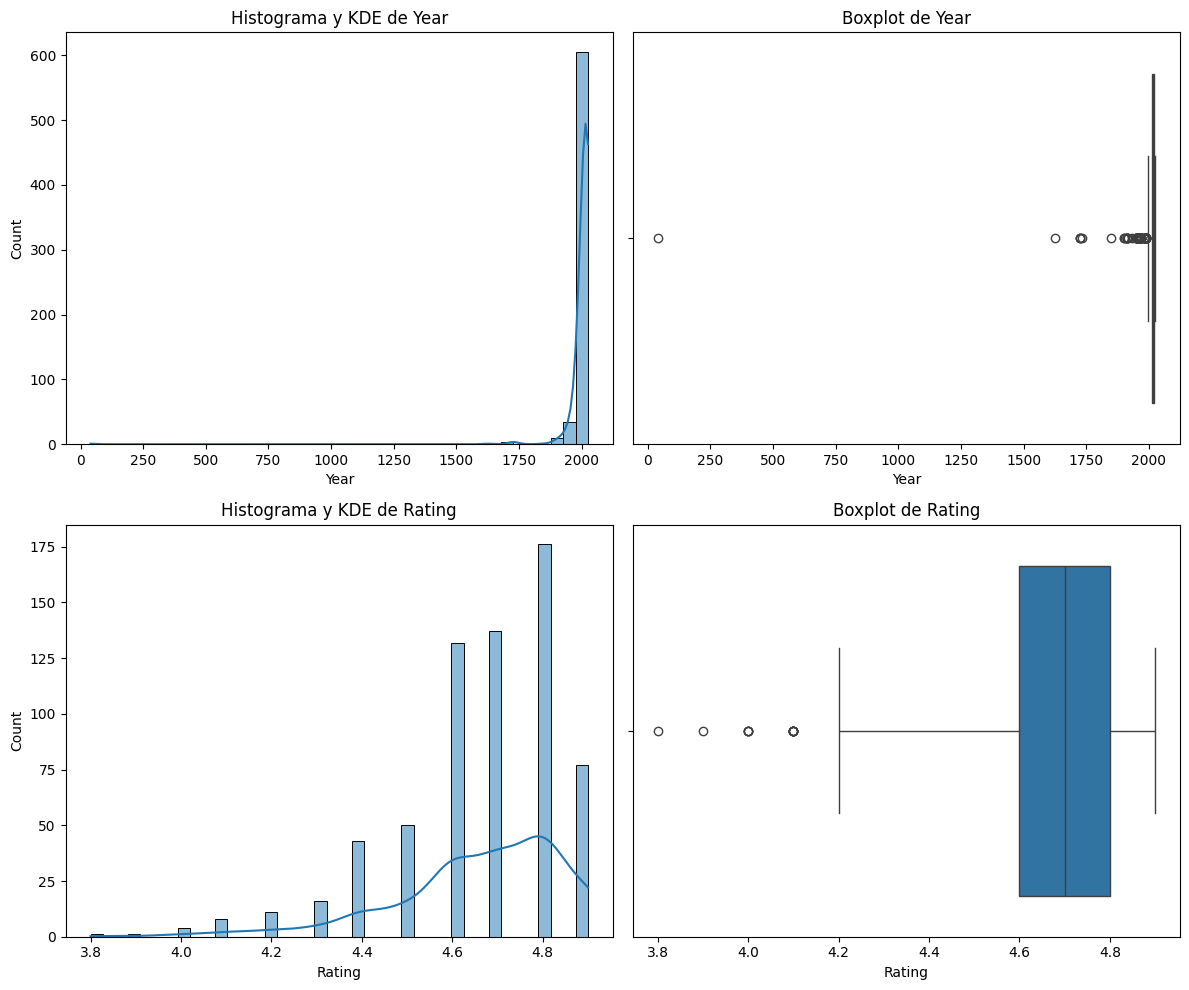

In [22]:
plot_combined_graphs(df, ["Year","Rating"], whisker_width=2, bins = 40)

(2,)


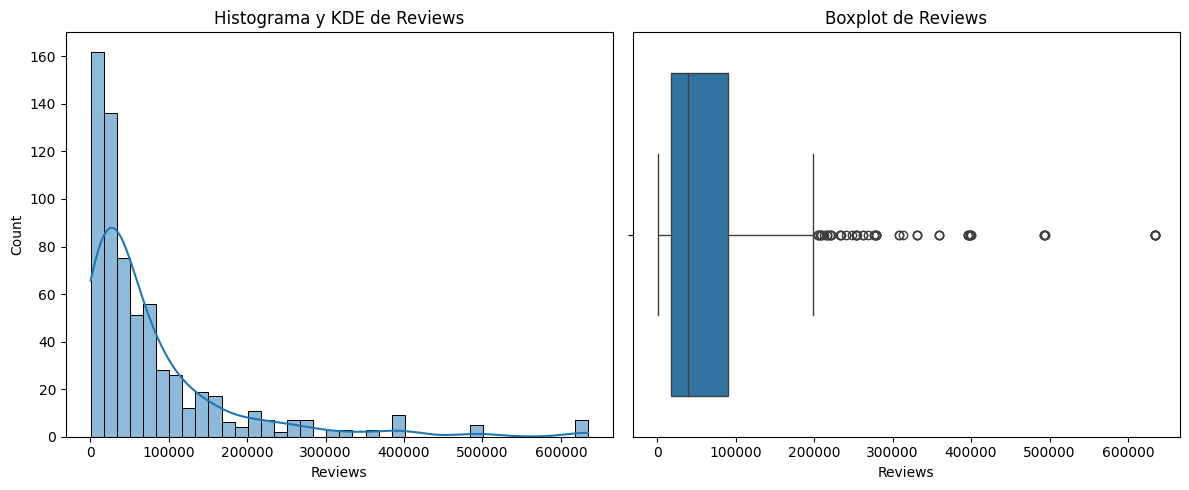

In [23]:
plot_combined_graphs(df,["Reviews"])

(2,)


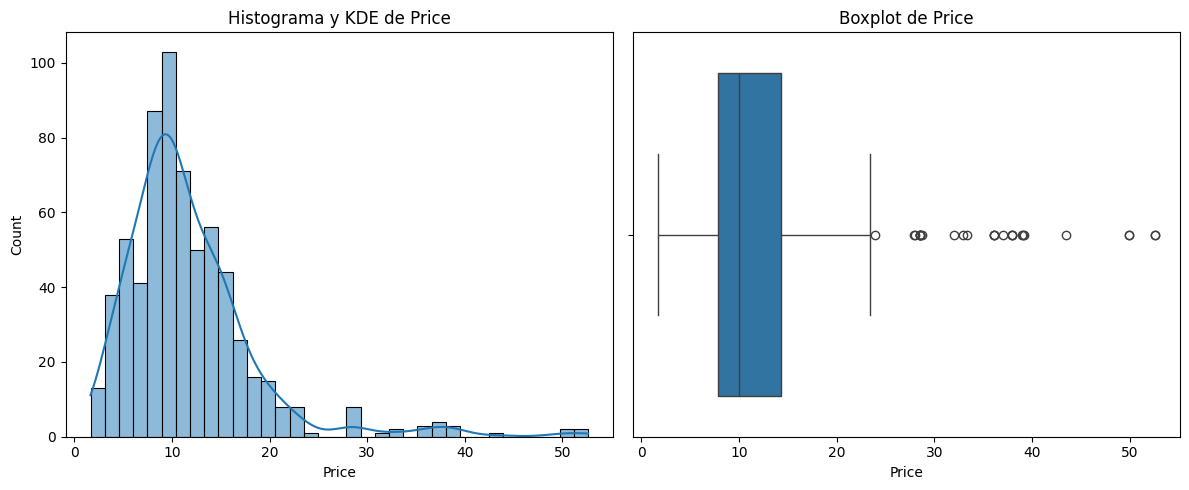

In [24]:
plot_combined_graphs(df,["Price"])

### Multivariant Analysis

* From (./src/data/amazon_analysis_II.ipynb)
* From (./src/data/amazon_analysis_III.ipynb)

In [27]:
pip install wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud

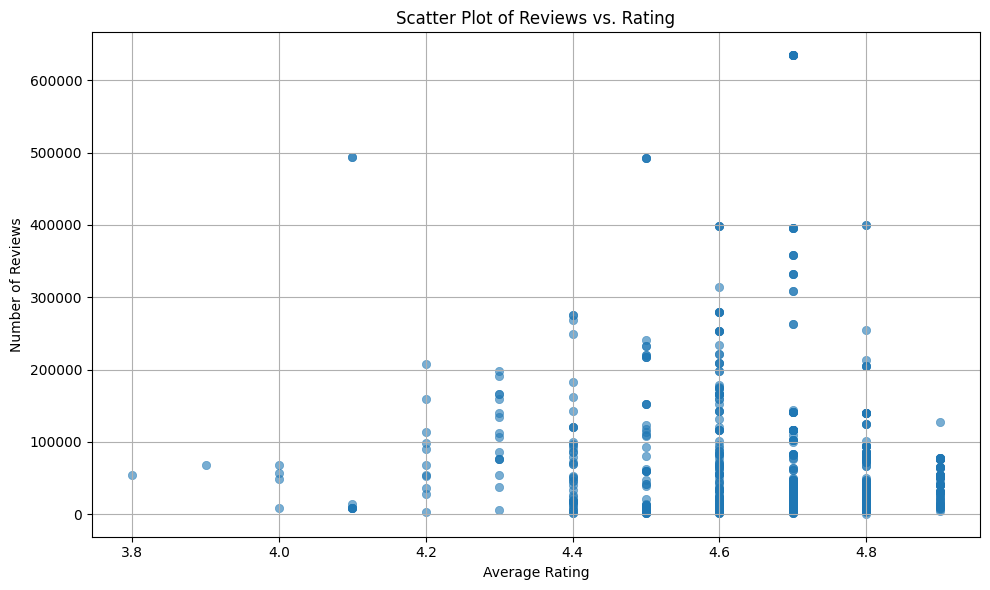

In [32]:
#Reviews vs Rating: A Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Rating', y='Reviews', alpha=0.6, edgecolor=None)

plt.title('Scatter Plot of Reviews vs. Rating')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()


Some outliers with number of reviews, could be bestsellers.
We will look at the trends now. 

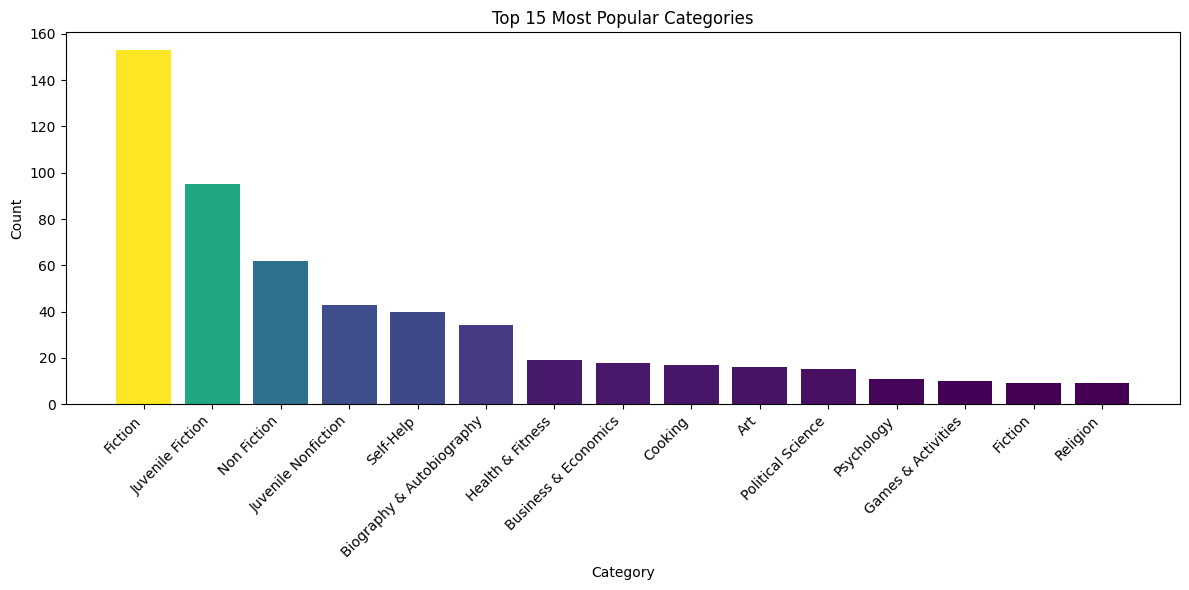

In [36]:
#Most popular categories overall

cat_counts = df['Categories'].value_counts().nlargest(15)

# Normalize values to map to colormap
norm = plt.Normalize(cat_counts.min(), cat_counts.max())
colors = cm.viridis(norm(cat_counts.values))

# Plot with gradient colors
plt.figure(figsize=(12, 6))
bars = plt.bar(cat_counts.index, cat_counts.values, color=colors)
plt.title('Top 15 Most Popular Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/1h/kvjqjlx908g4mdp8fc29vsb40000gr/T/ipykernel_90608/1283137254.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Year_Str'] = chunk['Amazon_year'].astype(str)
/var/folders/1h/kvjqjlx908g4mdp8fc29vsb40000gr/T/ipykernel_90608/1283137254.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


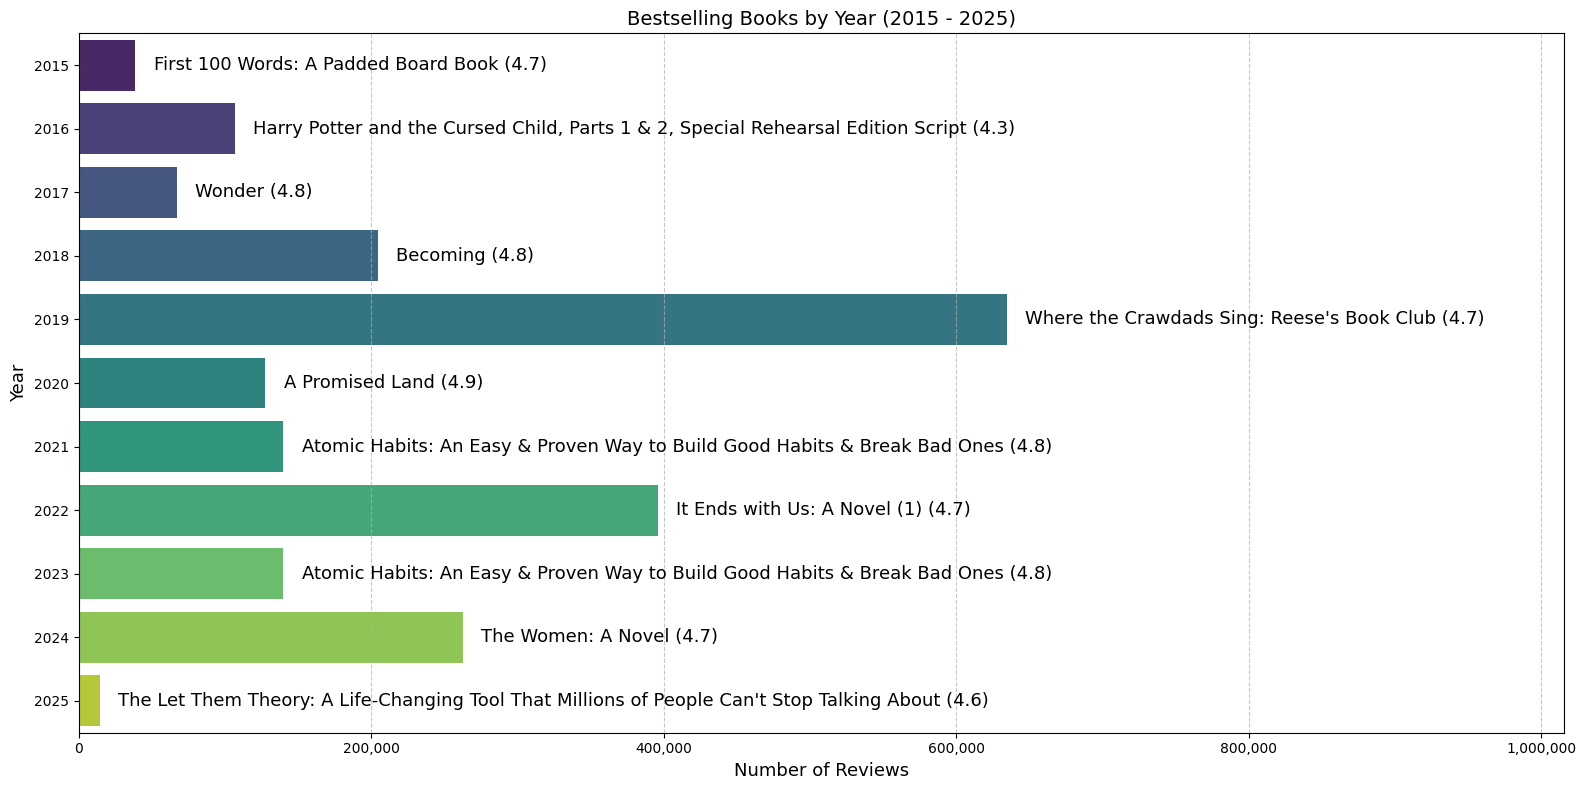

In [39]:
# Identify the first book (assumed bestseller) of each year
best_selling_per_year = df.groupby("Amazon_year").first().reset_index()

# Sort by year for consistent plotting
best_selling_per_year = best_selling_per_year.sort_values("Amazon_year")

# Use full titles without truncation
best_selling_per_year['Short_Title'] = best_selling_per_year['Title']

# Import required libraries if not already imported
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot charts with multiple years
def plot_multiple_charts(data, years_per_plot=11):
    # Process data in chunks to avoid too many years in one plot
    chunks = []
    for i in range(0, len(data), years_per_plot):
        chunks.append(data.iloc[i:i+years_per_plot])
    
    # Create a separate figure for each chunk
    for i, chunk in enumerate(chunks):
        # Create a larger figure to accommodate full-length titles
        plt.figure(figsize=(16, 8))
        
        # Convert year to string to treat it as categorical
        chunk['Year_Str'] = chunk['Amazon_year'].astype(str)
        
        # Create horizontal bar plot
        ax = sns.barplot(
            data=chunk,
            x="Reviews",  # Number of reviews (length of bars)
            y="Year_Str", # Years on y-axis
            palette="viridis"
        )
        
        # Add annotations for book titles and ratings - placing text outside the bars
        for j, row in enumerate(chunk.itertuples()):
            # Position text at end of bar plus small offset
            plt.text(
                row.Reviews + (chunk['Reviews'].max() * 0.02),  # Position text just outside the bar
                j,                   # Y position (index in the plot)
                f"{row.Short_Title} ({row.Rating:.1f})",  # Text with title and rating
                va="center",         # Vertically center
                fontsize=13,
                color='black'        # Black text for better readability
            )
        
        # Set titles and labels
        year_range = f"{chunk['Amazon_year'].min()} - {chunk['Amazon_year'].max()}"
        plt.title(f"Bestselling Books by Year ({year_range})", fontsize=14)
        plt.xlabel("Number of Reviews", fontsize=13)
        plt.ylabel("Year", fontsize=13)
        
        # Add grid lines for better readability
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Add extra space on the right side of the plot for title text
        plt.xlim(0, chunk['Reviews'].max() * 1.6)  # Extend x-axis to accommodate titles
        
        # Format x-axis with comma separators for large numbers
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
        
        # Save this chunk to a file
        filename = f"best_selling_books_part_{i+1}.png"
        plt.tight_layout()
        
       
        
        # Show the plot
        plt.show()

# Execute the function with the data
plot_multiple_charts(best_selling_per_year)

* What about across the years, is this comparable.

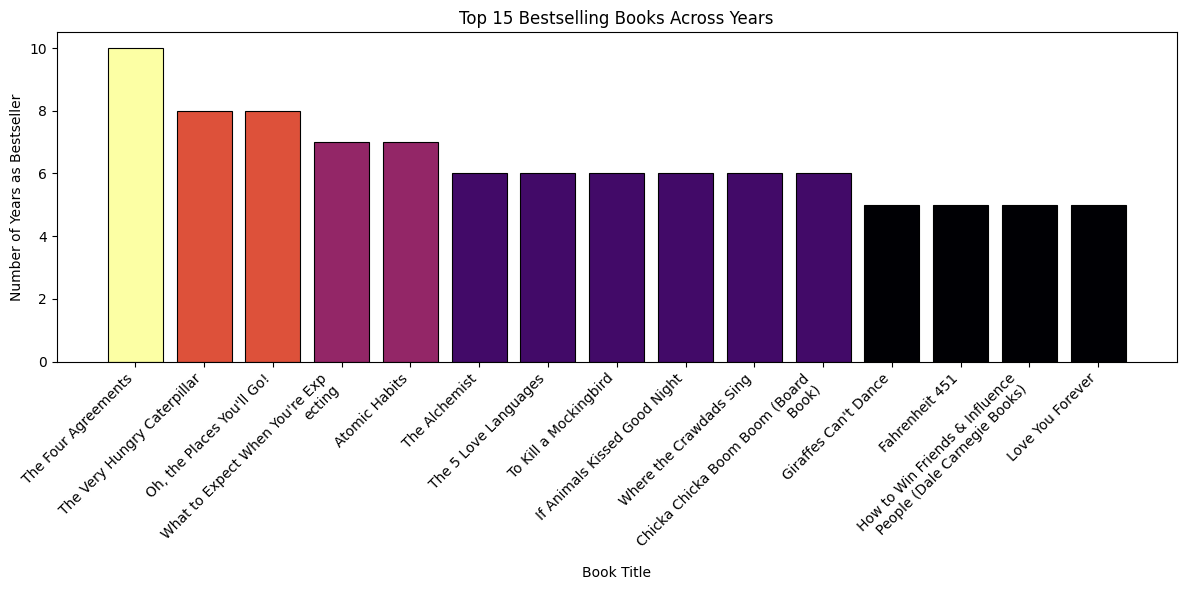

In [38]:

# Count how many times each book appears
top_books = df['Title'].value_counts().nlargest(15)
top_books.index = top_books.index.str.split(':').str[0].str.strip()

# Wrap long titles for display (at 30 chars)
wrapped_labels = [
    '\n'.join(title[i:i+30] for i in range(0, len(title), 30)) 
    for title in top_books.index
]

# Normalize for colormap
norm = plt.Normalize(top_books.min(), top_books.max())
colors = cm.inferno(norm(top_books.values))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(wrapped_labels, top_books.values, color=colors, edgecolor='black', linewidth=0.8)

# Customize
plt.title('Top 15 Bestselling Books Across Years')
plt.xlabel('Book Title')
plt.ylabel('Number of Years as Bestseller')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* This doesn´t appear to be replicated, these books are mostly Non Fiction. But the most popular category is Fiction overall.

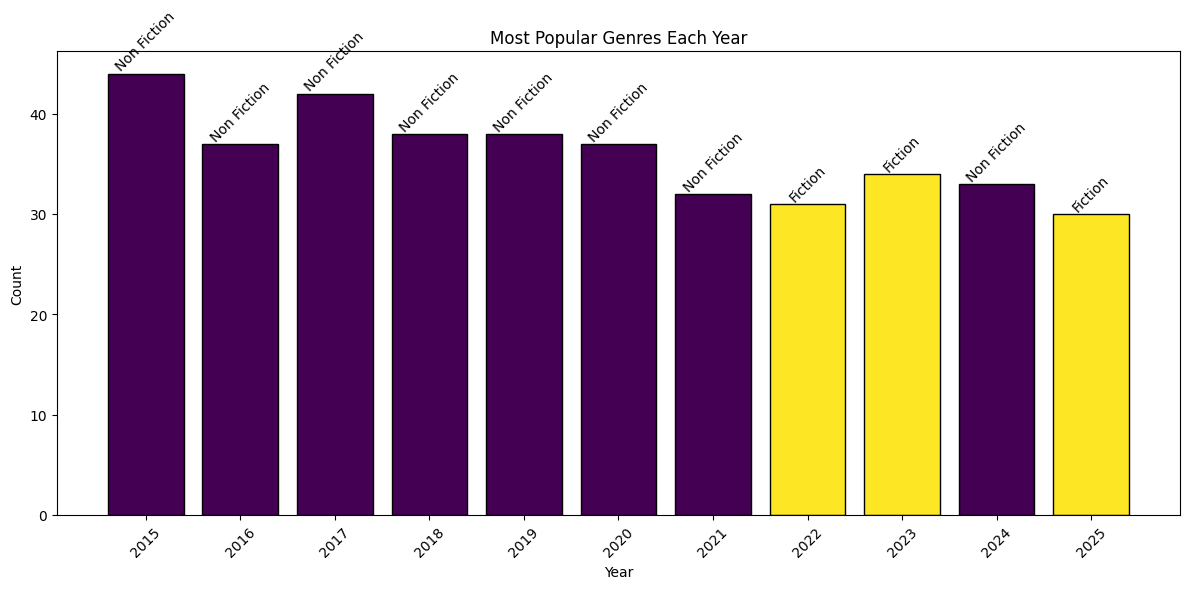

In [40]:
#Most popular genres: 
cat_counts_per_year = df.groupby(['Amazon_year', 'Genres']).size().reset_index(name='Count')




# Get the most popular category for each year
most_popular_per_year = cat_counts_per_year.loc[
    cat_counts_per_year.groupby('Amazon_year')['Count'].idxmax()
]
# Get unique categories
unique_categories = most_popular_per_year['Genres'].unique()

# Create a color map: Assign a unique color to each category
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_categories)))

# Create a dictionary to map each category to a color
category_to_color = {category: colors[i] for i, category in enumerate(unique_categories)}

# Assign colors to the bars based on the category
bar_colors = most_popular_per_year['Genres'].map(category_to_color)

# Plot the results
plt.figure(figsize=(12, 6))
bars = plt.bar(most_popular_per_year['Amazon_year'].astype(str), most_popular_per_year['Count'], 
               color=bar_colors, edgecolor='black')

# Annotate each bar with the category name at the top
for bar, category in zip(bars, most_popular_per_year['Genres']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), category, 
             ha='center', va='bottom', fontsize=10, rotation=45)

# Customize plot
plt.title('Most Popular Genres Each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

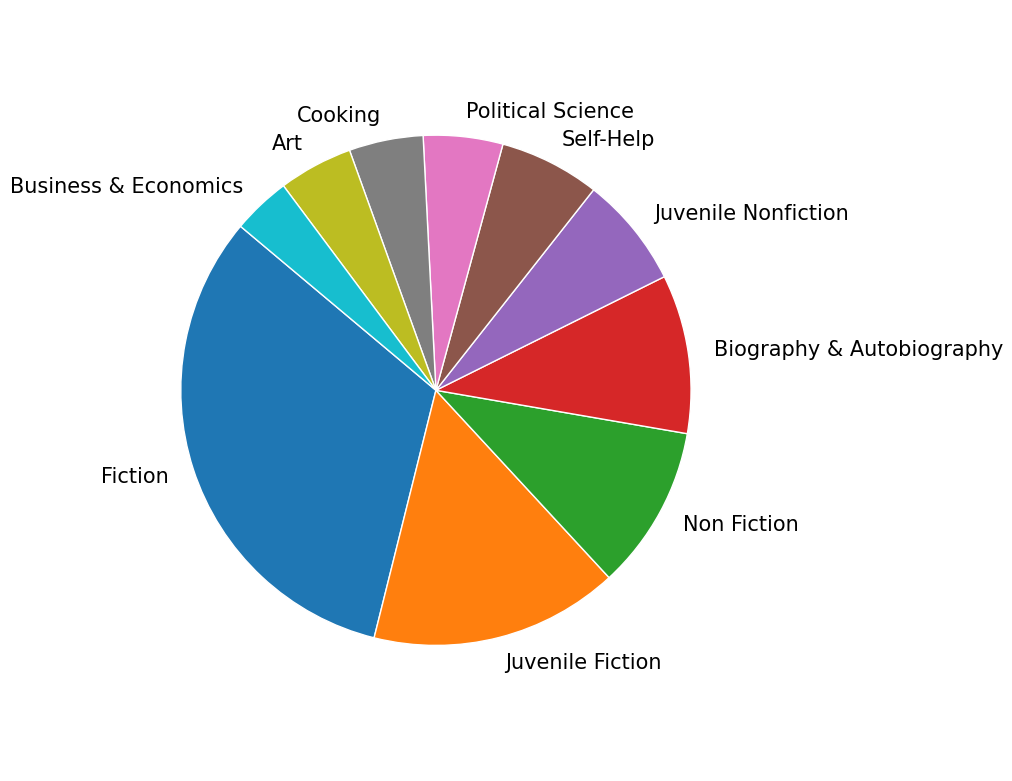

In [58]:
# Category percentage by popularity of book titles.
# Count distinct book titles per category
category_title_counts = df.groupby('Categories')['Title'].nunique().sort_values(ascending=False)

# Select top 15 categories
top_10_categories = category_title_counts.head(10)

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    top_10_categories,
    labels=top_10_categories.index,
   
    startangle=140,
    wedgeprops=dict(edgecolor='white'),
    textprops={'fontsize': 15}
    
)


plt.axis('equal')  # Ensures the pie is circular
plt.tight_layout()
plt.savefig("pie_bestselling_categories_book_titles", dpi=300, bbox_inches='tight')
plt.show()

* This makes more sense now, fiction books occupy the top popularity, however, the rest of the bestseller list is usually non fiction.
* What is the distribution for publishers?

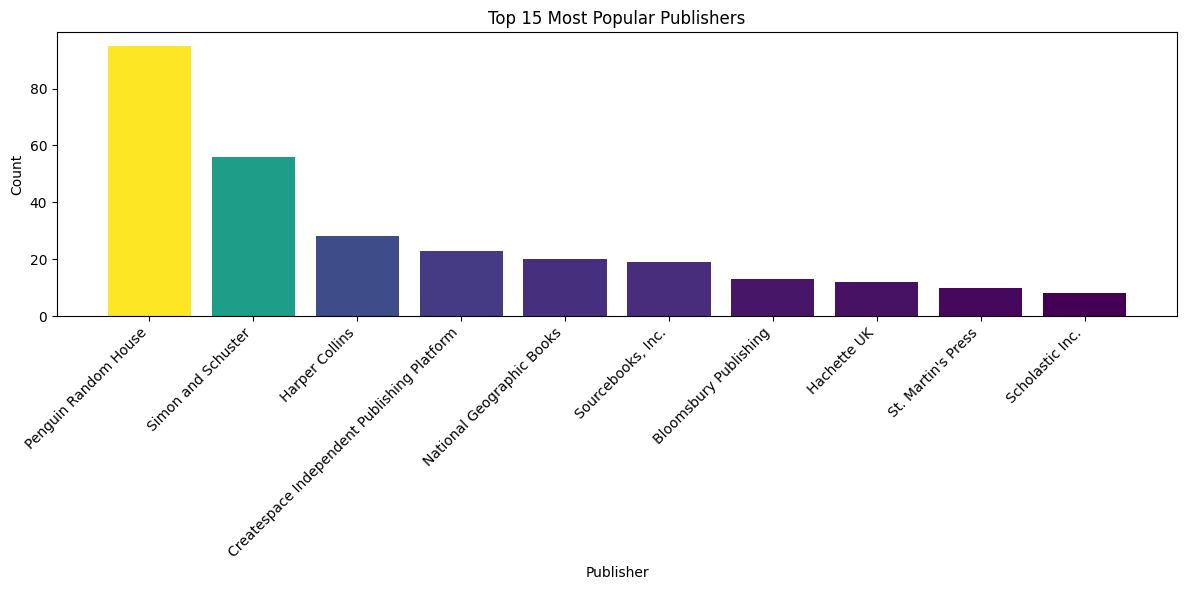

In [41]:
#Top 15 Most popular Publishers

cat_counts = df['Publisher'].value_counts().nlargest(10)

# Normalize values to map to colormap
norm = plt.Normalize(cat_counts.min(), cat_counts.max())
colors = cm.viridis(norm(cat_counts.values))

# Plot with gradient colors
plt.figure(figsize=(12, 6))
bars = plt.bar(cat_counts.index, cat_counts.values, color=colors)
plt.title('Top 15 Most Popular Publishers')
plt.xlabel('Publisher')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

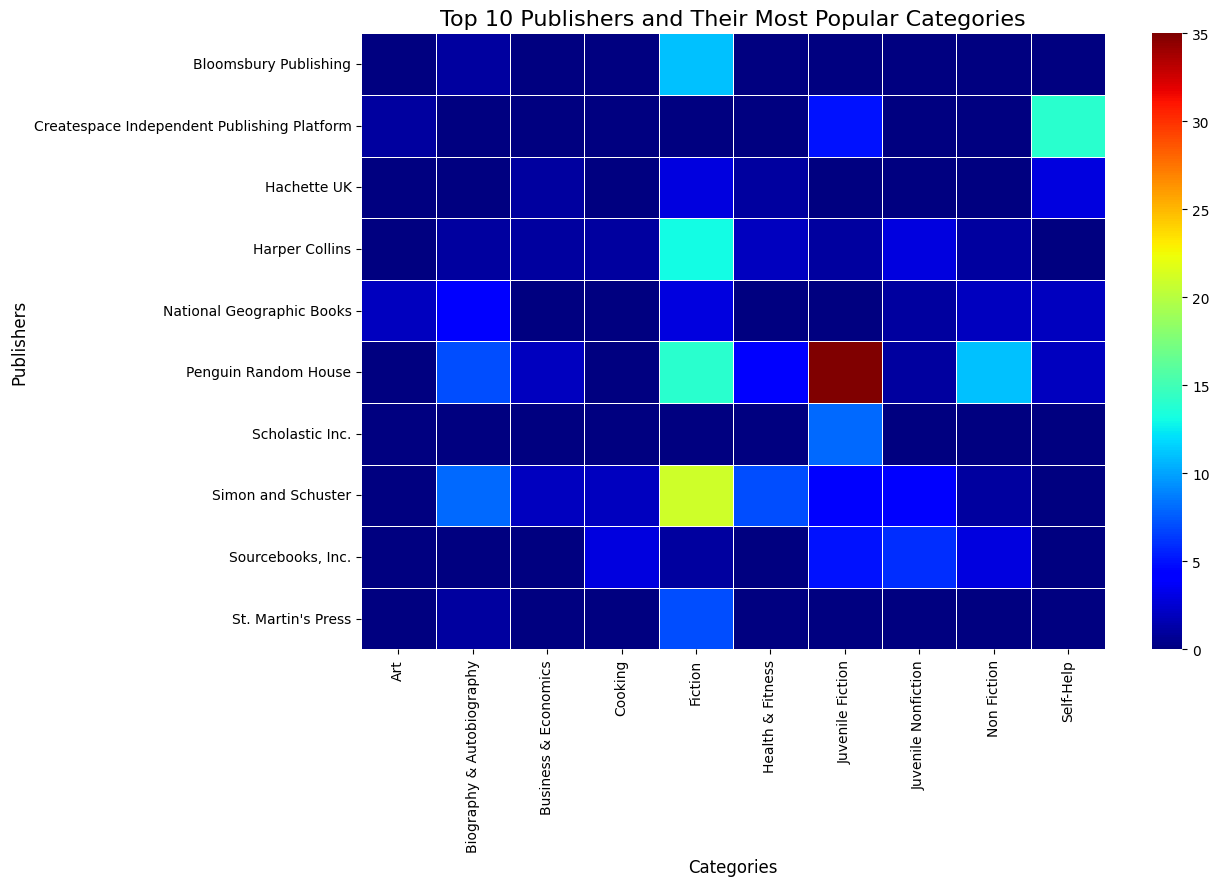

In [63]:

# Step 1: Filter the top 10 publishers and top 10 categories
top_publishers = df['Publisher'].value_counts().head(10).index
top_categories = df['Categories'].value_counts().head(10).index

# Filter the DataFrame to include only top 10 publishers and top 10 categories
filtered_df = df[df['Publisher'].isin(top_publishers) & df['Categories'].isin(top_categories)]

# Step 2: Group by 'Publisher' and 'Categories', and count the occurrences
publisher_category_counts = filtered_df.groupby(['Publisher', 'Categories']).size().unstack(fill_value=0)

# Step 3: Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(publisher_category_counts, annot=False, cmap='jet', fmt='d', linewidths=0.5)

# Step 4: Title and labels
plt.title('Top 10 Publishers and Their Most Popular Categories', fontsize=16)
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Publishers', fontsize=12)

# Show the plot
plt.show()


* Fiction and Juvenile fiction have the highest frequency for popularity, well move on to authors now. 

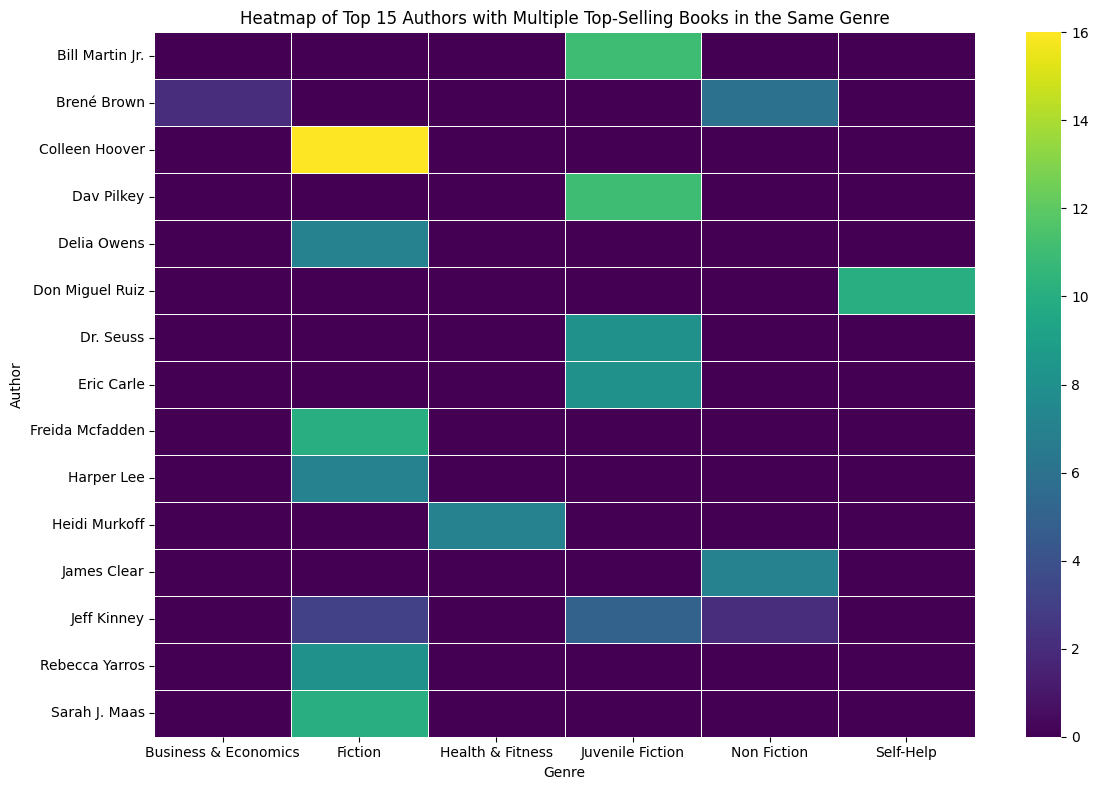

In [43]:
author_genre_counts = df.groupby(['Author', 'Categories']).size().reset_index(name='book_count')

# Filter out authors with only 1 book per genre
authors_with_multiple_books = author_genre_counts[author_genre_counts['book_count'] > 1]

# Get the top 10 authors based on the total number of books
top_15_authors = authors_with_multiple_books.groupby('Author')['book_count'].sum().nlargest(15).index

# Filter the original dataframe to include only the top 10 authors
top_10_data = authors_with_multiple_books[authors_with_multiple_books['Author'].isin(top_15_authors)]

# Pivot the data to create a matrix of authors vs genres
pivot_data = top_10_data.pivot_table(index='Author', columns='Categories', values='book_count', aggfunc='sum', fill_value=0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=False, cmap='viridis', fmt='d', linewidths=0.5, )

# Add title and labels
plt.title('Heatmap of Top 15 Authors with Multiple Top-Selling Books in the Same Genre')
plt.xlabel('Genre')
plt.ylabel('Author')

plt.tight_layout()
plt.show()


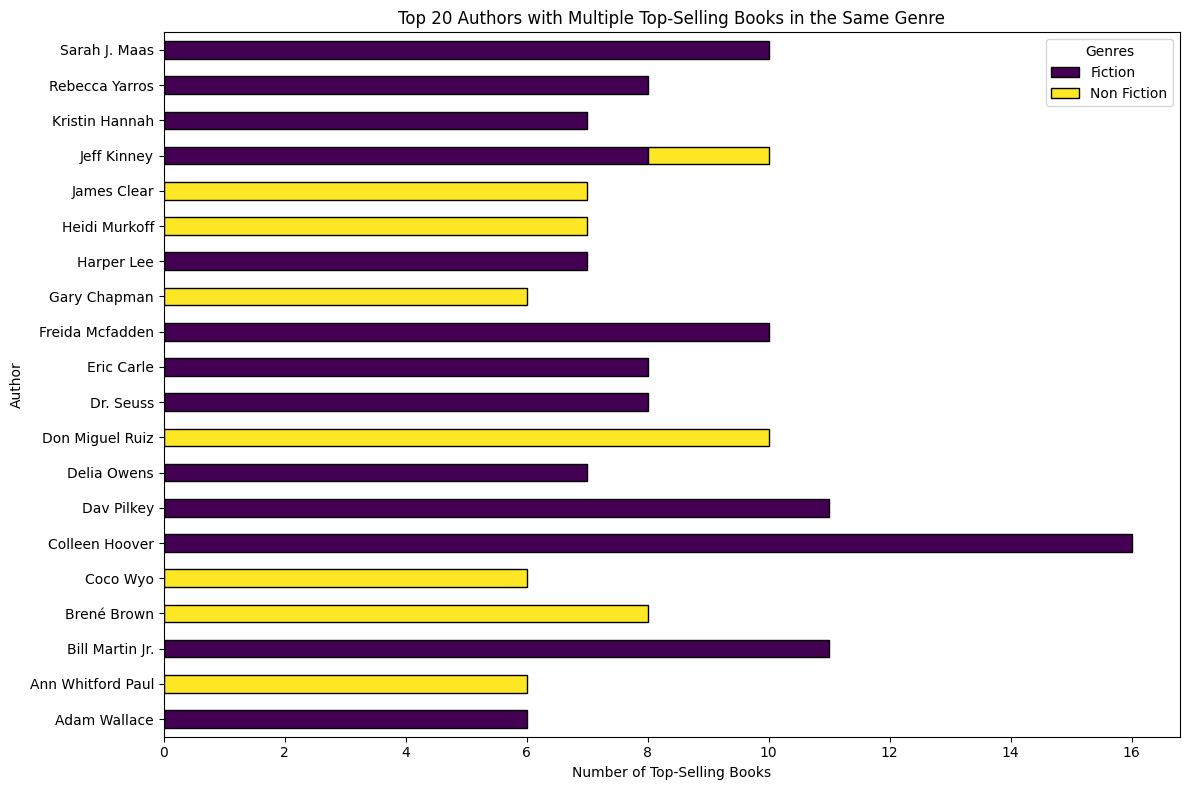

In [44]:
# Most  popular authors

author_genre_counts = df.groupby(['Author', 'Genres']).size().reset_index(name='book_count')
# Filter out authors with only 1 book per genre
authors_with_multiple_books = author_genre_counts[author_genre_counts['book_count'] > 1]
top_20_authors = authors_with_multiple_books.groupby('Author')['book_count'].sum().nlargest(20).index

# Filter the original dataframe to include only the top 10 authors
top_20_data = authors_with_multiple_books[authors_with_multiple_books['Author'].isin(top_20_authors)]

# Pivot the data to create a matrix of authors vs genres
pivot_data = top_20_data.pivot_table(index='Author', columns='Genres', values='book_count', aggfunc='sum', fill_value=0)

# Create a stacked bar plot
pivot_data.plot(kind='barh', stacked=True, figsize=(12, 8), cmap='viridis', edgecolor='black')

# Add title and labels
plt.title('Top 20 Authors with Multiple Top-Selling Books in the Same Genre')
plt.xlabel('Number of Top-Selling Books')
plt.ylabel('Author')

# Display the plot
plt.tight_layout()
plt.show()

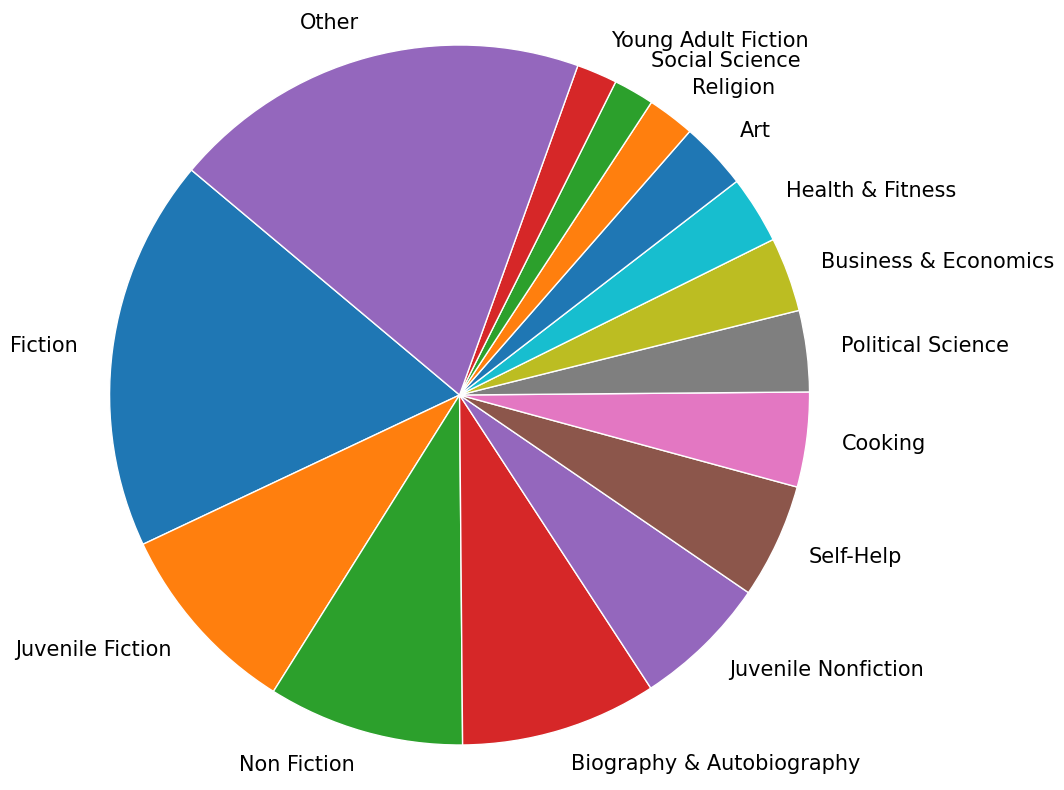

In [56]:
# Distribution of best selling authors per category

# Count distinct bestselling authors per category
category_author_counts = df.groupby('Categories')['Author'].nunique().sort_values(ascending=False)

# Keep top 14 categories, group the rest as "Other"
top_14 = category_author_counts.head(14)
other_total = category_author_counts[14:].sum()

# Combine into one series for plotting
category_combined = pd.concat([top_14, pd.Series({'Other': other_total})])

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    category_combined,
    labels=category_combined.index,
    
    startangle=140,
    wedgeprops=dict(edgecolor='white'),
    textprops={'fontsize': 15}
)


plt.axis('equal')  # Keep the pie chart circular
plt.tight_layout()

plt.show()

* While the top authors in Fiction/Juvenile Fiction have the most frequency in popularity, the distribution of top popular catgeories is onl 25%.
* Only few authors take the most popularity in Fiction/Juvenile fiction and overall.

* What about price? is Fiction/Juvenile fiction the most expensive and maybe more profitable due to its popularity?

/var/folders/1h/kvjqjlx908g4mdp8fc29vsb40000gr/T/ipykernel_90608/4112129655.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_per_category.values, y=avg_price_per_category.index, palette='viridis')


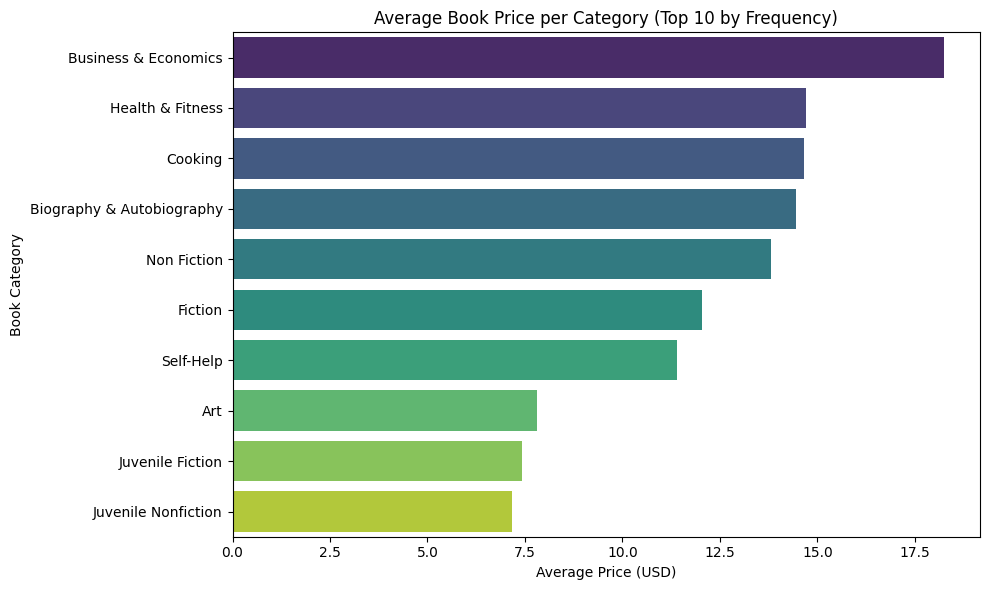

In [57]:


# Step 1: Count appearances per category and get the top 10
top_10_categories = df['Categories'].value_counts().head(10).index

# Step 2: Filter the DataFrame to only those categories
top_10_df = df[df['Categories'].isin(top_10_categories)]

# Step 3: Calculate average price per category
avg_price_per_category = top_10_df.groupby('Categories')['Price'].mean().sort_values(ascending=False)

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_per_category.values, y=avg_price_per_category.index, palette='viridis')

plt.title('Average Book Price per Category (Top 10 by Frequency)')
plt.xlabel('Average Price (USD)')
plt.ylabel('Book Category')
plt.tight_layout()

plt.show()


* It looks like, in terms of average price, Non fiction sells for a larger price.
* It would be interesting to look at the cost of manufacturing and developing Business, Health and Fitness and Cooking books to asses profitability.

* Finally, lets look at some themes that have been prevalent over the last decade.

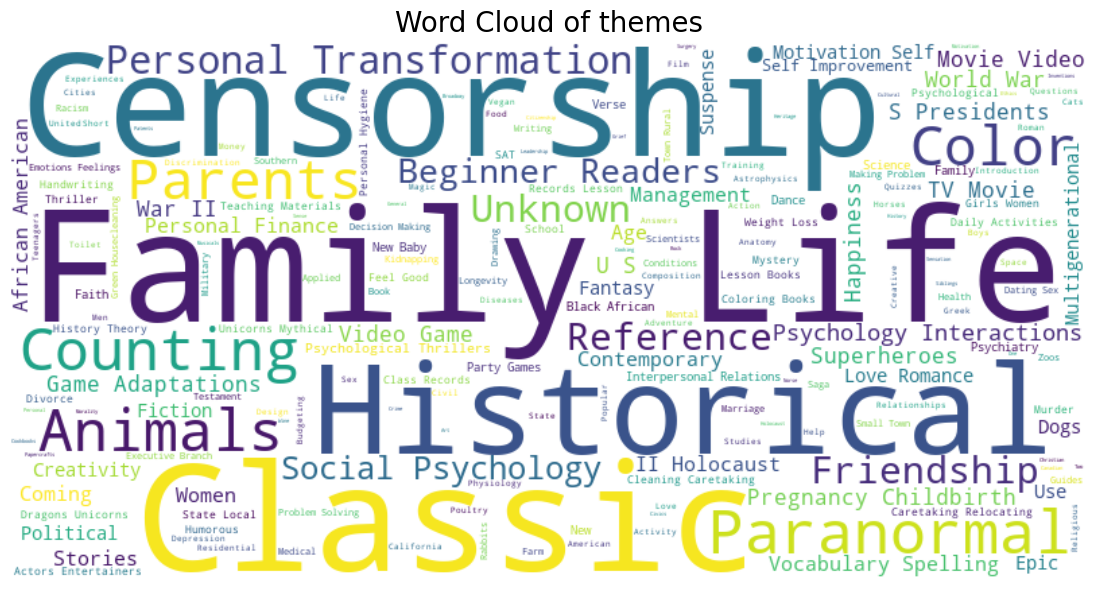

In [59]:
#Wordcloud Themes

# Combine all titles into one string for the word cloud
text = " ".join(df['Theme'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of themes", fontsize=20)


plt.show()

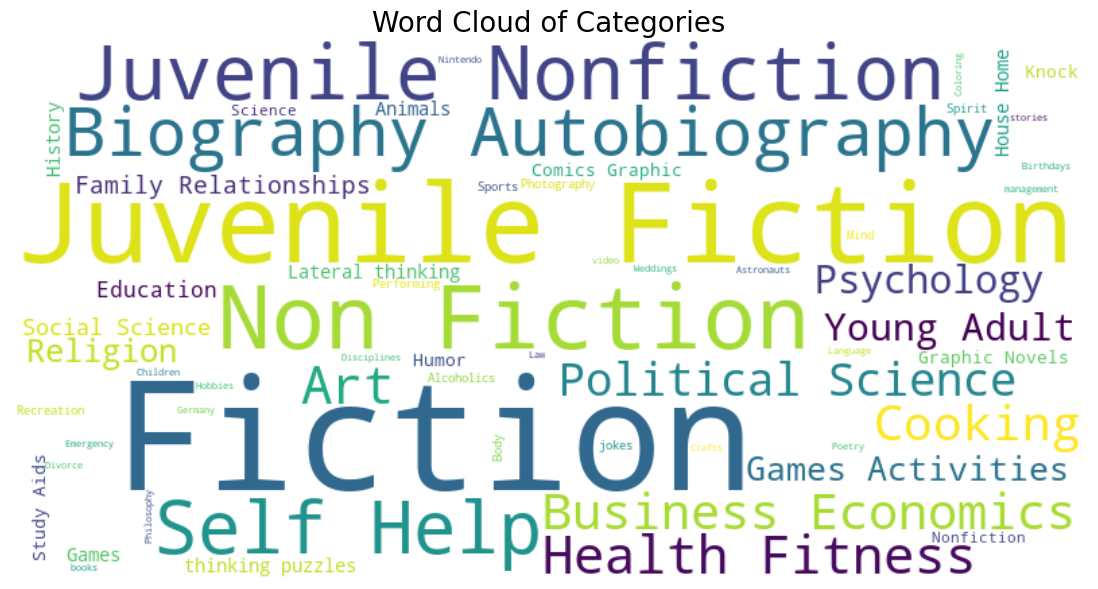

In [60]:
#Worldcloud categories

# Combine all titles into one string for the word cloud
text = " ".join(df['Categories'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Categories", fontsize=20)


plt.savefig("wordcloud_categrories", dpi=300, bbox_inches='tight')
plt.show()